In [227]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as torchF
import pandas as pd
import idx2numpy
import numpy as np

In [8]:
#creating 7x12 bitmapped images to train LeNet against
from bitstring import BitArray

def bitstring_to_pbm(bitstring_data, width, height, filename):
    """
    Converts a bitstring to a PBM image file.

    Args:
        bitstring_data: A bitstring object containing the image data.
        width: The width of the image in pixels.
        height: The height of the image in pixels.
        filename: The name of the PBM file to create.
    """
    if len(bitstring_data) != width * height:
        raise ValueError("Bitstring length does not match image dimensions.")

    with open(filename, 'w') as f:
        f.write("P1\n")  # PBM format header (ASCII)
        f.write(f"{width} {height}\n")  # Image dimensions

        # Write pixel data (1 for black, 0 for white)
        for i in range(height):
            for j in range(width):
                f.write(str(int(bitstring_data[i * width + j])) + " ")
            f.write("\n")

In [786]:
#need ascii 32 to 126
filename='ASCII_pbms/ASCII_126.pbm'
data = '''
0000000
0000000
0000000
0000000
0000000
0001001
0110110
0000000
0000000
0000000
0000000
0000000
'''

width = 7
height = 12
image_data = np.array(list(data.replace('\n', ''))).reshape(height, width).astype(np.int8)

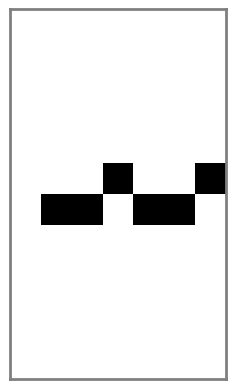

In [787]:
# Display the image using imshow
plt.imshow(image_data, cmap='gray_r')
ax = plt.gca()

# Set border properties
for spine in ax.spines.values():
    spine.set_edgecolor('grey')  # Set border color
    spine.set_linewidth(2)      # Set border thickness

# Remove the ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [788]:
#save image

data = BitArray(bin=data)

#check for file
if filename.split('/')[1] not in os.listdir('ASCII_pbms'):
    print('creating file', filename)
    bitstring_to_pbm(data, width, height, filename)
else:
    print('file already exists')

creating file ASCII_pbms/ASCII_126.pbm


In [443]:
#print PBM images
def read_pbm_file(filename):
    with open(filename, 'r') as f:
        l = f.readlines()
    bits = []
    for i in range(2, len(l)):
        lstr = l[i].replace('\n', '').replace(' ', '')
        bits.append([int(b) for b in lstr])

    bits = np.array(bits)
    return bits

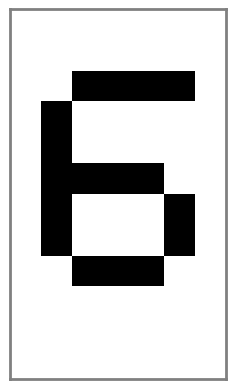

In [811]:
filename = 'ASCII_pbms/ASCII_54.pbm'
image_data = read_pbm(filename)

# Display the image using imshow
plt.imshow(image_data, cmap='gray_r')
ax = plt.gca()

# Set border properties
for spine in ax.spines.values():
    spine.set_edgecolor('grey')  # Set border color
    spine.set_linewidth(2)      # Set border thickness

# Remove the ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Training MNIST Against 7x12 Bitmapped ASCII Printable Chars

In the LeNet paper, loss function is a Euclidean RBF comparison of output layer against an "idealized" version of the inputs (7x12 bitmapped ASCII). I couldn't find a dataset for these online, so I recreated them. The section below recreates the single-char classification model from the first half of the LeNet paper

In [4]:
#dataset prep
ascii_map = open('emnist/emnist-byclass-mapping.txt', 'r').readlines()
ascii_map = dict([(int(l.rstrip().split(' ')[0]), int(l.rstrip().split(' ')[1])) for l in ascii_map])

col_names = ['class'] + ['pix'+str(i) for i in range(28*28)]
df_train = pd.read_csv('emnist/emnist-byclass-train.csv', names=col_names)
df_train['ascii#'] = df_train['class'].map(ascii_map)
df_test = pd.read_csv('emnist/emnist-byclass-test.csv', names=col_names)
df_test['ascii#'] = df_test['class'].map(ascii_map)

In [5]:
df_train.shape, df_test.shape

((697932, 786), (116323, 786))

79


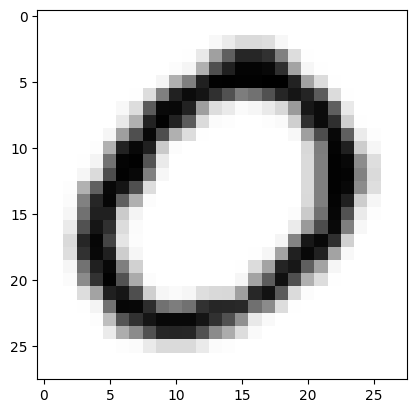

In [24]:
def print_img(df, idx):
    a = df_test.iloc[idx, 1:-1].to_numpy().reshape(28, 28).T
    print(df_test.iloc[idx, -1])
    plt.imshow(a, cmap='gray_r')

print_img(df_train, 46)

In [702]:
#load full printable ascii bitmap set into "parameter" tensor for model eval
bm_l = []
bm_dict = {}
for i, num in enumerate(sorted(pd.concat([df_test['ascii#'], df_train['ascii#']]).unique().tolist())):
    fname = f'ASCII_pbms/ASCII_{num}.pbm'
    arr = read_pbm_file(fname)
    bm_l.append(arr)
    bm_dict[num] = i

bm_param = torch.Tensor(np.array(bm_l)).reshape(62, 84)

In [899]:
#init hyperparams and weights
#hyperparams
F = 5 #size of square conv kernel
S = 1 #stride of conv kernel
B = 64 #batch dimension
SS = 2 #subsampling window size
act_list = {}

#weights
W1 = torch.randn((6, 1, 1, F, F)) / (F*F)
b1 = torch.randn((6, 1, 1))
w2 = torch.randn((6, 1, 1))
b2 = torch.randn((6, 1, 1))
W3_sparse_conv_idx = sum([[(i+x) % 6 for x in range(3)] for i in range(6)], [])
W3_sparse_conv_idx += sum([[(i+x) % 6 for x in range(4)] for i in range(6)], [])
W3_sparse_conv_idx += [0, 1, 3, 4, 1, 2, 4, 5, 0, 2, 3, 5] + list(range(6))
W3 = torch.randn((60, 1, 1, F, F)) / (F*F*60)
b3 = torch.randn((16, 1, 1))
w4 = torch.randn((16, 1, 1))
b4 = torch.randn((16, 1, 1))
W5 = torch.randn((120, 16, 5, 5)) / (F*F*16)
b5 = torch.randn(120)
W6 = torch.randn((120, 84)) / 120**0.5
b6 = torch.randn(84)

params = [W1, b1, w2, b2, W3, b3, w4, b4, W5, b5, W6, b6]
for p in params:
    p.requires_grad = True

In [922]:
#training loop
iters = 10000
losses = []
B = 32

for i in range(iters):
    
    #feedforward
    #retrieve sample batch, convert to numpy
    x_batch = df_train.sample(B).iloc[:, 1:].to_numpy()
    x, y = x_batch[:, :-1], x_batch[:, -1]
    
    #reshape to square matrix and zero pad 2-pixels on each side: (28x28) --> (32x32)
    x = x.reshape(B, 28, 28)
    x = torch.transpose(torch.Tensor(x), 1, 2)
    x = torchF.pad(x, pad=(2, 2, 2, 2), value=0.0)
    
    #normalize
    x = x / 255.0
    act_list['xin'] = x
    
    #convolution1
    x_conv1 = x.unfold(1, F, S).unfold(2, F, S).unsqueeze(1)
    x = (x_conv1 * W1).sum(dim=(-2, -1)) + b1
    #insert normalization here
    act_list['conv1'] = x
    x = x.sigmoid()
    
    #subsampling2
    x = x.unfold(2, SS, SS).unfold(3, SS, SS).sum(dim=(-2, -1))
    x /= float(SS*SS)
    x = x * w2 + b2
    act_list['ss2'] = x
    x = x.sigmoid()
    
    #conv3, uses special sparse connections
    #define sparse convolutional connections
    
    #applying sparse conv index, unfold into convs
    x_conv3 = x[:, W3_sparse_conv_idx, :, :].unfold(2, F, S).unfold(3, F, S)
    x = (x_conv3 * W3).sum(dim=(-2, -1))
    #sum together 60 convs into 16 feature maps
    W3_sparse_summed = [x[:, 3*i:3*(i+1), :, :].sum(dim=1, keepdim=True) for i in range(6)] 
    W3_sparse_summed += [x[:, 18+4*i:18+4*(i+1), :, :].sum(dim=1, keepdim=True) for i in range(9)]
    W3_sparse_summed += [x[:, 54:60, :, :].sum(dim=1, keepdim=True)]
    
    x = torch.cat(W3_sparse_summed, dim=1)
    x += b3
    act_list['conv3'] = x
    x = x.sigmoid()
    
    #subsamp4
    x = x.unfold(2, SS, SS).unfold(3, SS, SS).sum(dim=(-2, -1))
    x /= float(SS*SS)
    x = x * w4 + b4
    act_list['ss4'] = x
    
    #conv5
    x = (x.unsqueeze(1) * W5).sum(dim=(-3, -2, -1)) + b5
    act_list['conv5'] = x
    x = x.sigmoid()
    
    #F6, fully connected
    x = x @ W6 + b6
    act_list['f6'] = x
    x = torchF.tanh(x) #tanh in paper instead of sigmoid like other layers
    
    #O7, output layer
    x = (x.unsqueeze(-1) - bm_param.T).square().sum(dim=1)
    x /= 84.0
    act_list['out7'] = x.reshape(-1)
    
    #backpropagation
    
    #loss function
    #get index of y_pred value
    y_idx = np.vectorize(lambda x: bm_dict[x])(y)
    loss = (x[np.arange(x.shape[0]), y_idx] + (x*-1).exp().sum(axis=1).log()).mean()

    assert 1 == 2
    
    #backprop/gradient update
    loss.backward()
    if i % 500 == 0:
        losses.append(loss.item())
        print('loss:', loss.item())
    lr = 0.1
    for p in params:
        p.data += -lr * p.grad
        p.grad = None

AssertionError: 

In [928]:
#feedforward
#retrieve sample batch, convert to numpy
x_batch = df_train.sample(B).iloc[:, 1:].to_numpy()
x, y = x_batch[:, :-1], x_batch[:, -1]

#reshape to square matrix and zero pad 2-pixels on each side: (28x28) --> (32x32)
x = x.reshape(B, 28, 28)
x = torch.transpose(torch.Tensor(x), 1, 2)
x = torchF.pad(x, pad=(2, 2, 2, 2), value=0.0)

#normalize
x = x / 255.0
act_list['xin'] = x

#convolution1
x_conv1 = x.unfold(1, F, S).unfold(2, F, S).unsqueeze(1)
x = (x_conv1 * W1).sum(dim=(-2, -1)) + b1
#insert normalization here
act_list['conv1'] = x
x = x.sigmoid()

#subsampling2
x = x.unfold(2, SS, SS).unfold(3, SS, SS).sum(dim=(-2, -1))
x /= float(SS*SS)
x = x * w2 + b2
act_list['ss2'] = x
x = x.sigmoid()

#conv3, uses special sparse connections
#define sparse convolutional connections

#applying sparse conv index, unfold into convs
x_conv3 = x[:, W3_sparse_conv_idx, :, :].unfold(2, F, S).unfold(3, F, S)
x = (x_conv3 * W3).sum(dim=(-2, -1))
#sum together 60 convs into 16 feature maps
W3_sparse_summed = [x[:, 3*i:3*(i+1), :, :].sum(dim=1, keepdim=True) for i in range(6)] 
W3_sparse_summed += [x[:, 18+4*i:18+4*(i+1), :, :].sum(dim=1, keepdim=True) for i in range(9)]
W3_sparse_summed += [x[:, 54:60, :, :].sum(dim=1, keepdim=True)]

x = torch.cat(W3_sparse_summed, dim=1)
x += b3
act_list['conv3'] = x
x = x.sigmoid()

#subsamp4
x = x.unfold(2, SS, SS).unfold(3, SS, SS).sum(dim=(-2, -1))
x /= float(SS*SS)
x = x * w4 + b4
act_list['ss4'] = x

#conv5
x = (x.unsqueeze(1) * W5).sum(dim=(-3, -2, -1)) + b5
act_list['conv5'] = x
x = x.sigmoid()

#F6, fully connected
x = x @ W6 + b6
act_list['f6'] = x
x = torchF.tanh(x) #tanh in paper instead of sigmoid like other layers

#O7, output layer
x = (x.unsqueeze(-1) - bm_param.T).square().sum(dim=1)
x /= 84.0
act_list['out7'] = x.reshape(-1)

#backpropagation

#loss function
#get index of y_pred value
y_idx = np.vectorize(lambda x: bm_dict[x])(y)
loss = (x[np.arange(x.shape[0]), y_idx] + (x*-1).exp().sum(axis=1).log()).mean()
loss.backward()

xin: 0.14211246371269226, 0.09577467292547226
conv1: -0.399623841047287, 0.5792636275291443
ss2: -0.2575722634792328, 1.1335166692733765
conv3: -0.0034137158654630184, 0.7037933468818665
ss4: 0.14168471097946167, 1.25027334690094
conv5: 1.6812866926193237, 5.591800689697266
f6: -0.8346354365348816, 7.863012790679932
out7: 1.1368834972381592, 0.032359637320041656


/tmp/ipykernel_3220/3971368989.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


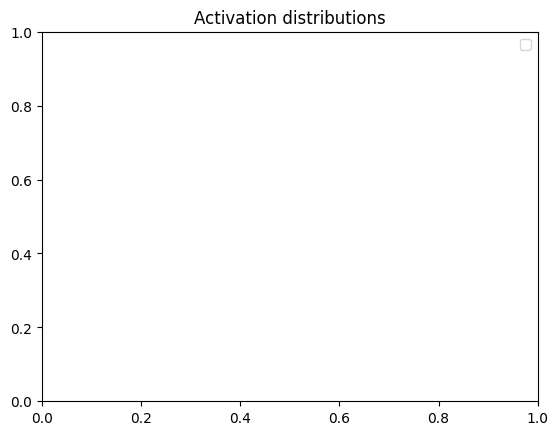

In [921]:
#visualize activations and gradients
# Plotting multiple histograms
for k in act_list.keys():
    #plt.hist(act_list[k].reshape(-1), bins=30, alpha=0.7, label=f'act_list_{k}', histtype='step')
    print(f'{k}: {act_list[k].mean()}, {act_list[k].var()}')
    
# Adding labels and title
plt.title('Activation distributions')
plt.legend(loc='upper right')

# Displaying the plot
plt.show()

In [915]:
#variance in each sample in batch across layers
for k in act_list.keys():
    print(f'{k}: {act_list[k].var(axis=0).mean()}', act_list[k].var())

xin: 0.05785477161407471 tensor(0.0813)
conv1: 0.0032598867546766996 tensor(0.5718, grad_fn=<VarBackward0>)
ss2: 0.00022257043747231364 tensor(1.1300, grad_fn=<VarBackward0>)
conv3: 3.598132991555758e-07 tensor(0.7037, grad_fn=<VarBackward0>)
ss4: 2.824909017817845e-08 tensor(1.2502, grad_fn=<VarBackward0>)
conv5: 2.5290905369956818e-08 tensor(5.5916, grad_fn=<VarBackward0>)
f6: 5.208836695302921e-10 tensor(7.8628, grad_fn=<VarBackward0>)
out7: 0.0323651060461998 tensor(0.0324, grad_fn=<VarBackward0>)


tensor(-2.4555e-08) tensor(7.2144e-15)
tensor(-8.5968e-08) tensor(1.0462e-13)
tensor(-4.7846e-07) tensor(1.5541e-13)
tensor(-1.2172e-06) tensor(7.1132e-13)
tensor(-8.5029e-07) tensor(5.2648e-12)
tensor(-1.6875e-06) tensor(2.2021e-11)
tensor(-3.0341e-06) tensor(1.6642e-10)
tensor(-3.0456e-06) tensor(4.8410e-10)
tensor(-1.4138e-07) tensor(7.0005e-11)
tensor(-9.9787e-07) tensor(5.4586e-11)
tensor(2.1306e-05) tensor(4.6442e-09)
tensor(2.9152e-05) tensor(6.9677e-09)


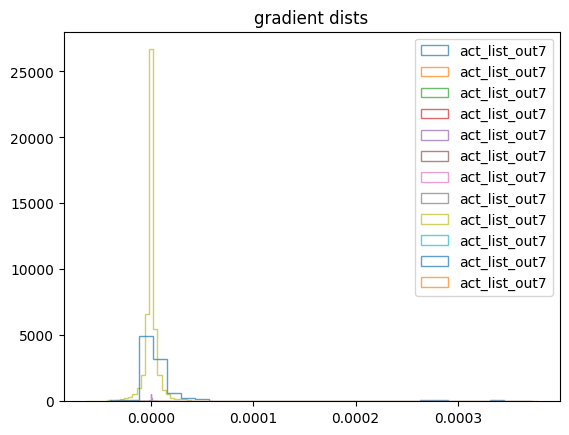

In [930]:
for p in params:
    plt.hist(p.grad.reshape(-1), bins=30, alpha=0.7, label=f'act_list_{k}', histtype='step')
    print(p.grad.mean(), p.grad.var())

plt.title('gradient dists')
plt.legend(loc='upper right')
plt.show()

## Classification of entire sections of Handwriting

after creating the simpler single-char predictor, LeNet specifies a graph structure for OCR on full sections of handwritten text. The creation of dataset and recreation of that model is below

In [34]:

#creation of handwritten text dataset
splits = {'train': 'data/train.parquet', 'validation': 'data/validation.parquet', 'test': 'data/test.parquet'}
df_train = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["test"])

#define types
df_train['type'] = 'train'
df_val['type'] = 'validation'
df_test['type'] = 'test'


#concat, isolate image bytestrings, save
df = pd.concat([df_train, df_val, df_test])
df['bytes'] = df.image.apply(lambda x: x['bytes'])
df[['text', 'bytes', 'type']].to_parquet('df.parquet.gzip', compression='gzip') 

In [35]:
df

,text,image,type,bytes
0,put down a resolution on the subject,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,and he is to be backed by Mr. Will,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,nominating any more Labour life Peers,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,M Ps tomorrow. Mr. Michael Foot has,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"Griffiths, M P for Manchester Exchange .",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,train,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...
2910,"just dusty-grey but muddy , slimy even .",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2911,"the fake friend of the family , like the",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2912,"client's eyes , the dust of fake security , of",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2913,"the result being somehow as ineffective , not",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,test,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
